# 頻度論で傾向スコアを求める

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gpboost as gpb
from patsy import dmatrix

In [2]:
filepath = '../../../../../../data/processed/df_filtered_5years.xlsx'
df = pd.read_excel(filepath)
df = df.dropna()

In [3]:
log_income = np.log(df['income'])
density = df['population'] / df['area_km2']

def log (data):
    return np.log(data + 1)

def standardize(data):
    return (data - data.mean()) / data.std()

def log_standardize(data):
    return (log(data) - log(data).mean()) / log(data).std()

standard_income = log_standardize(df['income'])
standard_area = log_standardize(df['area_km2'])
standard_dist = log_standardize(df['distance_m'])
standard_density = log_standardize(density)

In [4]:
treatment = df['dummy_island_has_bridge']
covariates = dmatrix('standard_income + standard_area + standard_dist + standard_density + C(year)', data=df, return_type='dataframe')
group = df['island_id']

gp_model = gpb.GPModel(group_data=group, likelihood='bernoulli_logit')
gp_model.fit(treatment, covariates, params={'std_dev': True})
gp_model.summary()
propensity_scores = gp_model.predict(X_pred=covariates, group_data_pred=group)['mu']

Model summary:
 Log-lik    AIC    BIC
  -37.19 100.38 162.82
Nb. observations: 901
Nb. groups: 152 (island_id)
-----------------------------------------------------
Covariance parameters (random effects):
              Param.
island_id  4588.7714
-----------------------------------------------------
Linear regression coefficients (fixed effects):
                   Param.  Std. dev.  z value  P(>|z|)
Intercept        -24.7345    12.1203  -2.0408   0.0413
C(year)[T.1990]    0.3892    12.6444   0.0308   0.9754
C(year)[T.1995]   -0.4183    10.3140  -0.0406   0.9676
C(year)[T.2000]    1.0157    10.4194   0.0975   0.9223
C(year)[T.2005]    2.3543    11.2918   0.2085   0.8348
C(year)[T.2010]    3.4701    11.4145   0.3040   0.7611
C(year)[T.2015]    4.8669    11.4366   0.4256   0.6704
C(year)[T.2020]    6.4079    11.4144   0.5614   0.5745
standard_income   -0.7636     3.1306  -0.2439   0.8073
standard_area     21.4943     6.9369   3.0985   0.0019
standard_dist    -30.9491     5.9210  -5.2270 

In [5]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x=, y=propensity_scores, hue=treatment);

SyntaxError: invalid syntax (4020000313.py, line 2)

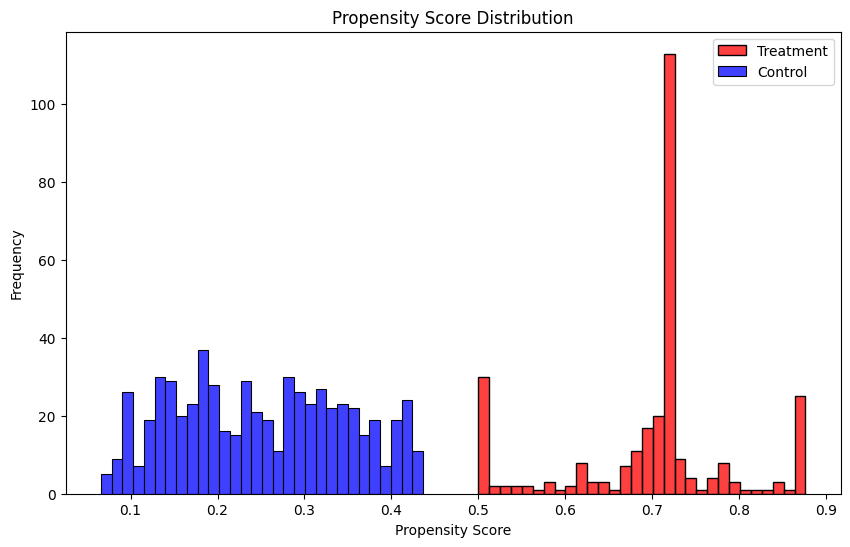

In [14]:
# 傾向スコアの分布をプロット
plt.figure(figsize=(10, 6))
sns.histplot(propensity_scores[treatment == 1], bins=30, color='red', label='Treatment')
sns.histplot(propensity_scores[treatment == 0], bins=30, color='Blue', label='Control')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.title('Propensity Score Distribution')
plt.legend()
plt.show()